
We import some necessary libraries.

In [1]:
# For ML
import torch
from torch import Tensor
import torchvision.transforms as Transform
from torch.utils.data import Dataset

# For reading raw data.
import json
import nibabel as nib

# For displaying and evaluating results.
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

# For monitoring resource-usage and progress.
from tqdm import tqdm # Install ipywidgets to remove warning.
import os, sys, psutil
from os.path import join, exists

Check if GPU is available and retrieve some system stats.

In [2]:
# Setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using', device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('CUDA version:', torch.version.cuda)

available_ram = round(psutil.virtual_memory()[0]/1000000000,2)
print('RAM: ' + str(available_ram) + 'GB')

Using cuda
NVIDIA GeForce GTX 1070
CUDA version: 11.7
RAM: 16.74GB


Setting up some global constants.

In [3]:
root_dir = '../' # Location of project, relative to the working directory.
raw_data_dir = join(root_dir, 'raw_data')
prep_data_dir = join(root_dir, 'augmenteddata')

d = 256 # New dimensions (width and height) of datapoints.
num_chunks = 10 # Number of chunks to divide our data into.
cmap_seg = ListedColormap(['none', 'red']) # For drawing tumors in red.

And some utility functions.

In [4]:
def superimpose(image, label):
    plt.imshow(image, cmap='gray')
    plt.imshow(label, cmap=cmap_seg)
    plt.show()

We prep and format datasets from raw data for each specified organ, using the above function. We save progress after each organ is completed. Can be interrupted and resumed at any time, and accounts for progress, which has already been made. We define a function which loads and stores our data in the proper formatting. As the datasets are huge and have to concatenate each set of 240 slices to the previous, we monitor progress and RAM-usage.

In [5]:
def prep_data(organ, mode, type, transform):
    with open(join(raw_data_dir, organ, 'dataset.json')) as f:
        manifest = json.load(f)[mode]
    
    bar = tqdm(total=len(manifest))
    bar.set_description('Prepping ' + organ + ' ' + mode + ' ' + type + 's')
    
    try: 
        images = torch.zeros((0, d, d))

        for entry in manifest:
            bar.set_postfix(**{'RAM':round(psutil.virtual_memory()[3]/10e8, 2)})
            bar.update()

            nii_img = nib.load(join(raw_data_dir, organ, entry[type][2:]))

            # Convert to numpy array, then pytorch tensor.
            nii_data = Tensor(nii_img.get_fdata())

            # Scale between 0 and 1.
            nii_data -= nii_data.min()
            nii_data /= nii_data.max()
            nii_data = nii_data.permute(2, 0, 1) # (slice, rows, columns)
            nii_data = transform(nii_data)
            images = torch.cat((images, nii_data), 0)
        
        torch.save(images, join(prep_data_dir, organ + '_' + mode + '_' + type + '_slices.pt'))

    except KeyboardInterrupt:
        print('Manually stopped.')
    
    bar.close()

We call the preprocessor function for different organs

In [6]:
resize = Transform.Resize((d, d))
organs = ['pancreas'] # Simply add to this list.
do_prep = False

if do_prep:
    for organ in organs:
        prep_data(organ,'training','image',resize)
        prep_data(organ,'training','label',resize)
else:
    print('Data already prepped.')

Data already prepped.


We define a custom dataset class.

In [7]:
class CT_Dataset(Dataset):
    def __init__(self, path, organ, mode):
        self.images = torch.load(
            join(path, organ + '_' + mode + '_image_slices.pt'))
        
        self.labels = torch.load(
            join(path, organ + '_' + mode + '_label_slices.pt'))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        return self.images[index], self.labels[index]

    def show_datapoint(self, index):
        image, label = self.__getitem__(index)
        superimpose(image, label)

In [8]:
training_set = CT_Dataset(prep_data_dir, 'lung', 'training')

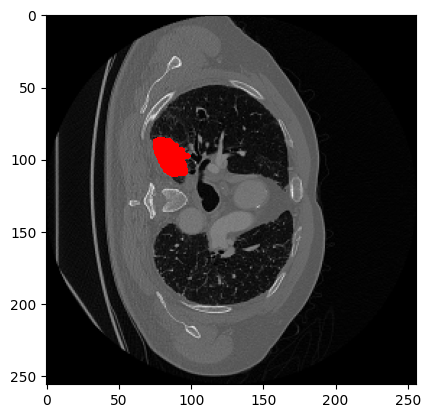

In [9]:
training_set.show_datapoint(900)